# imputation and modeling
sklearn modeling the median imputed training data using min/max clinically guided aggregation. 
preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

# importing and formatting dataset

In [4]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df
from parameters import save_boolean
#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]



time: 19.4 ms


In [5]:
print(folder)

24_hr_window
time: 661 µs


In [6]:
  address=str(repository_path)+'/data/cleaned_merged_agg/'+'%s/'%(folder)
train_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'train')), index_col=0)
test_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'test')), index_col=0)

time: 124 ms


In [7]:
train_data.head()

,icustay_id,any_vasoactives,bilirubin,bun,cancer_elix,chloride,creatinine,daily_sofa,dobutamine,dopamine,...,"('min', 'calcium')","('min', 'sodium')","('min', 'wbc')",ethnicity,gender,bands,pao2fio2ratio,pco2,weight,yearsold
0,200012.0,0.0,NaN,NaN,0.0,NaN,NaN,-0.430677,0.0,0.0,...,NaN,NaN,-0.319914,asian,0.0,>10,"(475, 3000]",absent,51.2,32.988959
1,200014.0,0.0,NaN,0.040770,0.0,0.037089,-0.300758,-0.178747,0.0,0.0,...,-0.044882,0.014580,0.125353,unknown/other,1.0,absent,"(200, 333]",<50,62.0,84.728186
2,200033.0,1.0,NaN,-0.082229,1.0,-0.004314,-0.219047,-0.430677,0.0,0.0,...,-0.505654,-0.011213,-0.195493,white/nonhispanic,1.0,absent,"(475, 3000]",absent,74.0,67.145099
3,200036.0,0.0,NaN,NaN,0.0,NaN,NaN,-0.430677,0.0,0.0,...,NaN,NaN,NaN,white/nonhispanic,1.0,absent,"(475, 3000]",absent,79.0,74.934136
4,200055.0,0.0,-0.316061,0.098917,0.0,-0.035714,1.934240,0.503859,0.0,0.0,...,-0.135281,-0.003710,-0.260497,NaN,NaN,absent,"(475, 3000]",absent,56.0,NaN


time: 28 ms


## getting descriptive numbers for publication

In [8]:
final_pt_df2.head()#['icustay_id'].nunique()

,icustay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,...,subject_id,dod_hosp,dod_ssn,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin,hadm_id
0,294638,2191-03-16 00:00:00,22,2191-03-16 00:29:31,1213116,2191-03-16,2191-03-22,0 days 00:00:00.000000000,2191-03-16,2191-03-22,...,4,NaN,NaN,full,STAPH AUREUS COAG +,BLOOD CULTURE,2191-03-16 00:00:00,positive,C_pos/A_full,185777
1,220597,2149-11-10 09:40:00,45,2149-11-09 13:07:02,2089126,2149-11-10,2149-11-15,0 days 00:00:00.000000000,2149-11-10,2149-11-15,...,9,2149-11-14,2149-11-14,full,NaN,NaN,2149-11-10 09:40:00,negative,C_neg/A_full,150750
2,232669,2104-08-11 00:00:00,60,2104-08-08 02:08:17,616189,2104-08-11,2104-08-12,0 days 00:00:00.000000000,2104-08-11,2104-08-12,...,12,2104-08-20,2104-08-20,partial,NaN,NaN,2104-08-11 00:00:00,negative,C_neg/A_partial,112213
3,273430,2108-08-05 20:42:00,69,2108-08-05 16:26:09,2572274,2108-08-06,2108-08-08,1 days 00:00:00.000000000,2108-08-06,2108-08-08,...,19,NaN,2109-08-18,partial,NaN,NaN,2108-08-05 20:42:00,negative,C_neg/A_partial,109235
4,217847,2134-09-11 09:35:00,70,2134-09-11 20:50:04,1388217,2134-09-12,2134-09-13,1 days 00:00:00.000000000,2134-09-12,2134-09-13,...,21,2135-02-08,2135-02-08,full,NaN,NaN,2134-09-11 09:35:00,negative,C_neg/A_full,109451


time: 21.8 ms


In [9]:
list(train_data)

['icustay_id',
 'any_vasoactives',
 'bilirubin',
 'bun',
 'cancer_elix',
 'chloride',
 'creatinine',
 'daily_sofa',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'leukocyte',
 'nitrite',
 'norepinephrine',
 'o2_flow',
 'phenylephrine',
 'potassium',
 'ptt',
 'resprate',
 'rrt',
 'sum_elix',
 'temperature',
 'vasopressin',
 'vent_recieved',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 "('max', 'calcium')",
 "('max', 'sodium')",
 "('max', 'wbc')",
 "('min', 'calcium')",
 "('min', 'sodium')",
 "('min', 'wbc')",
 'ethnicity',
 'gender',
 'bands',
 'pao2fio2ratio',
 'pco2',
 'weight',
 'yearsold']

time: 2.62 ms


In [10]:
full_demo=pd.concat([train_data[['icustay_id','yearsold','ethnicity','gender']],test_data[['icustay_id','yearsold','ethnicity','gender']]])

time: 6.4 ms


In [11]:
full_demo.describe()

,icustay_id,yearsold,gender
count,10305.000000,6831.000000,6831.000000
mean,249857.183212,64.355019,0.552042
std,28968.046750,17.763457,0.497321
min,200012.000000,16.022154,0.000000
25%,224498.000000,52.468778,0.000000
50%,249804.000000,66.219555,1.000000
75%,275055.000000,78.838347,1.000000
max,299995.000000,90.000000,1.000000


time: 21 ms


In [12]:
full_demo.head()

,icustay_id,yearsold,ethnicity,gender
0,200012.0,32.988959,asian,0.0
1,200014.0,84.728186,unknown/other,1.0
2,200033.0,67.145099,white/nonhispanic,1.0
3,200036.0,74.934136,white/nonhispanic,1.0
4,200055.0,NaN,NaN,NaN


time: 6.99 ms


In [13]:
full_demo.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    7867
C_pos/A_full       2438
Name: final_bin, dtype: int64

time: 19 ms


In [14]:
full_demo['yearsold'].min()

16.0221538076406

time: 2.65 ms


In [15]:
full_demo['ethnicity'].value_counts()

white/nonhispanic    4906
unknown/other         845
black                 602
hispanic              280
asian                 198
Name: ethnicity, dtype: int64

time: 4.38 ms


In [16]:
full_demo['gender'].value_counts()

1.0    3771
0.0    3060
Name: gender, dtype: int64

time: 4.04 ms


In [17]:
test_data[['icustay_id','yearsold','ethnicity','gender']].head()

,icustay_id,yearsold,ethnicity,gender
0,200030.0,54.191893,black,1.0
1,200063.0,37.073163,unknown/other,1.0
2,200078.0,NaN,NaN,NaN
3,200109.0,NaN,NaN,NaN
4,200116.0,56.506077,white/nonhispanic,1.0


time: 10.2 ms


In [18]:
train_data.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 22.1 ms


## back to the modeling

In [19]:
def preprocessing(preimp_df):

    """
    function operations:
    1) rename columns
    2) standardize last 2 columns to be standardized
    3) convert categorical columns to proper format
    4) median impute
    """
    from sklearn.impute import SimpleImputer
        
    rename_dic={
    "('max', 'sodium')": "maxSodium" ,
    "('max', 'sodium')" : "maxSodium",
    "('min', 'sodium')" : "minSodium",
    "('max', 'calcium')" : "maxCalcium",
    "('min', 'calcium')" : "minCalcium",
    "('max', 'sodium')": "maxSodium",
    "('min', 'sodium')": "minSodium",
    "('max', 'wbc')": "maxWBC",
    "('min', 'wbc')": "minWBC",
    "bands": "ibands",
    "pco2": "ipco2"
        }
    data=preimp_df.copy()
    data=data.rename(rename_dic, axis='columns').copy()
    data.loc[data['yearsold']>90,"yearsold"]=90
    
    
    #train_data=data.copy()
    weight_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).median()
    weight_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
    weight_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
    weight_iqr=weight_quant3-weight_quant1
    #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

    age_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).median()
    age_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.25)
    age_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.75)
    age_iqr=age_quant3-age_quant1

    #converting to log scaled standardized data for age/weight
    data['weight']=data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
    data['yearsold']=data['yearsold'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
    ### onehot encoding categorical var
    cols_to_transform=['ethnicity', 'ibands', 'ipco2',
                       'any_vasoactives',"leukocyte","nitrite",
                       'pao2fio2ratio', 'vent_recieved',  "dobutamine",
                       "dopamine","epinephrine","norepinephrine",
                       "phenylephrine","rrt","vasopressin",'cancer_elix' ]
    data = pd.get_dummies(data, columns = cols_to_transform, drop_first=True)
    
    
    #binarizing and poping outcome for training data
    data.loc[data['final_bin']=="C_pos/A_full","final_bin"]=1
    data.loc[data['final_bin']=="C_neg/A_partial","final_bin"]=0
    data['final_bin']=pd.to_numeric(data['final_bin'])
    
    
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    data=pd.DataFrame(imp.fit_transform(data), columns=list(data))

    ## establishing training data and labels
    x_train= data.copy()
    z_icustay_id=x_train.pop('icustay_id')
    y_train= x_train.pop("final_bin").values
    
    return(x_train, y_train, z_icustay_id)

# x_train, y_train, z_icustay_id= preprocessing(pd.merge(preimp_train_df, final_pt_df2[['icustay_id','final_bin']]))

time: 109 ms


In [20]:

# x_train, y_train, z_icustay_id= preprocessing(pd.merge(preimp_train_df, final_pt_df2[['icustay_id','final_bin']]))

time: 519 µs


In [21]:
x_train, y_train, z_icustay_id = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]))
x_test, y_test, z_icustay_id_test= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]))

z_subject_id=pd.merge(pd.DataFrame(z_icustay_id), final_pt_df2[['icustay_id','subject_id']], how='left')['subject_id'] #7205

time: 257 ms


In [22]:
### added 11/8/19: removed daily sofa score from prediction model, since the components used to calculate it are already in model
x_train.drop('daily_sofa', axis=1, inplace=True)
x_test.drop('daily_sofa', axis=1, inplace=True)

time: 6.24 ms


In [23]:
len(list(x_train))

56

time: 2.25 ms


### getting table for paper

In [24]:
list(x_train)

['bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'o2_flow',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'gender',
 'weight',
 'yearsold',
 'ethnicity_black',
 'ethnicity_hispanic',
 'ethnicity_unknown/other',
 'ethnicity_white/nonhispanic',
 'ibands_>10',
 'ibands_absent',
 'ipco2_>50',
 'ipco2_absent',
 'any_vasoactives_1.0',
 'leukocyte_1.0',
 'nitrite_1.0',
 'pao2fio2ratio_(200, 333]',
 'pao2fio2ratio_(333, 475]',
 'pao2fio2ratio_(475, 3000]',
 'vent_recieved_1.0',
 'vent_recieved_2.0',
 'dobutamine_1.0',
 'dopamine_1.0',
 'epinephrine_1.0',
 'norepinephrine_1.0',
 'phenylephrine_1.0',
 'rrt_1.0',
 'vasopressin_1.0',
 'cancer_elix_1.0']

time: 2.94 ms


In [25]:
pd.merge(train_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 21.6 ms


In [26]:
pd.merge(test_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    2355
C_pos/A_full        745
Name: final_bin, dtype: int64

time: 18.6 ms


## looking at correlation of all variables

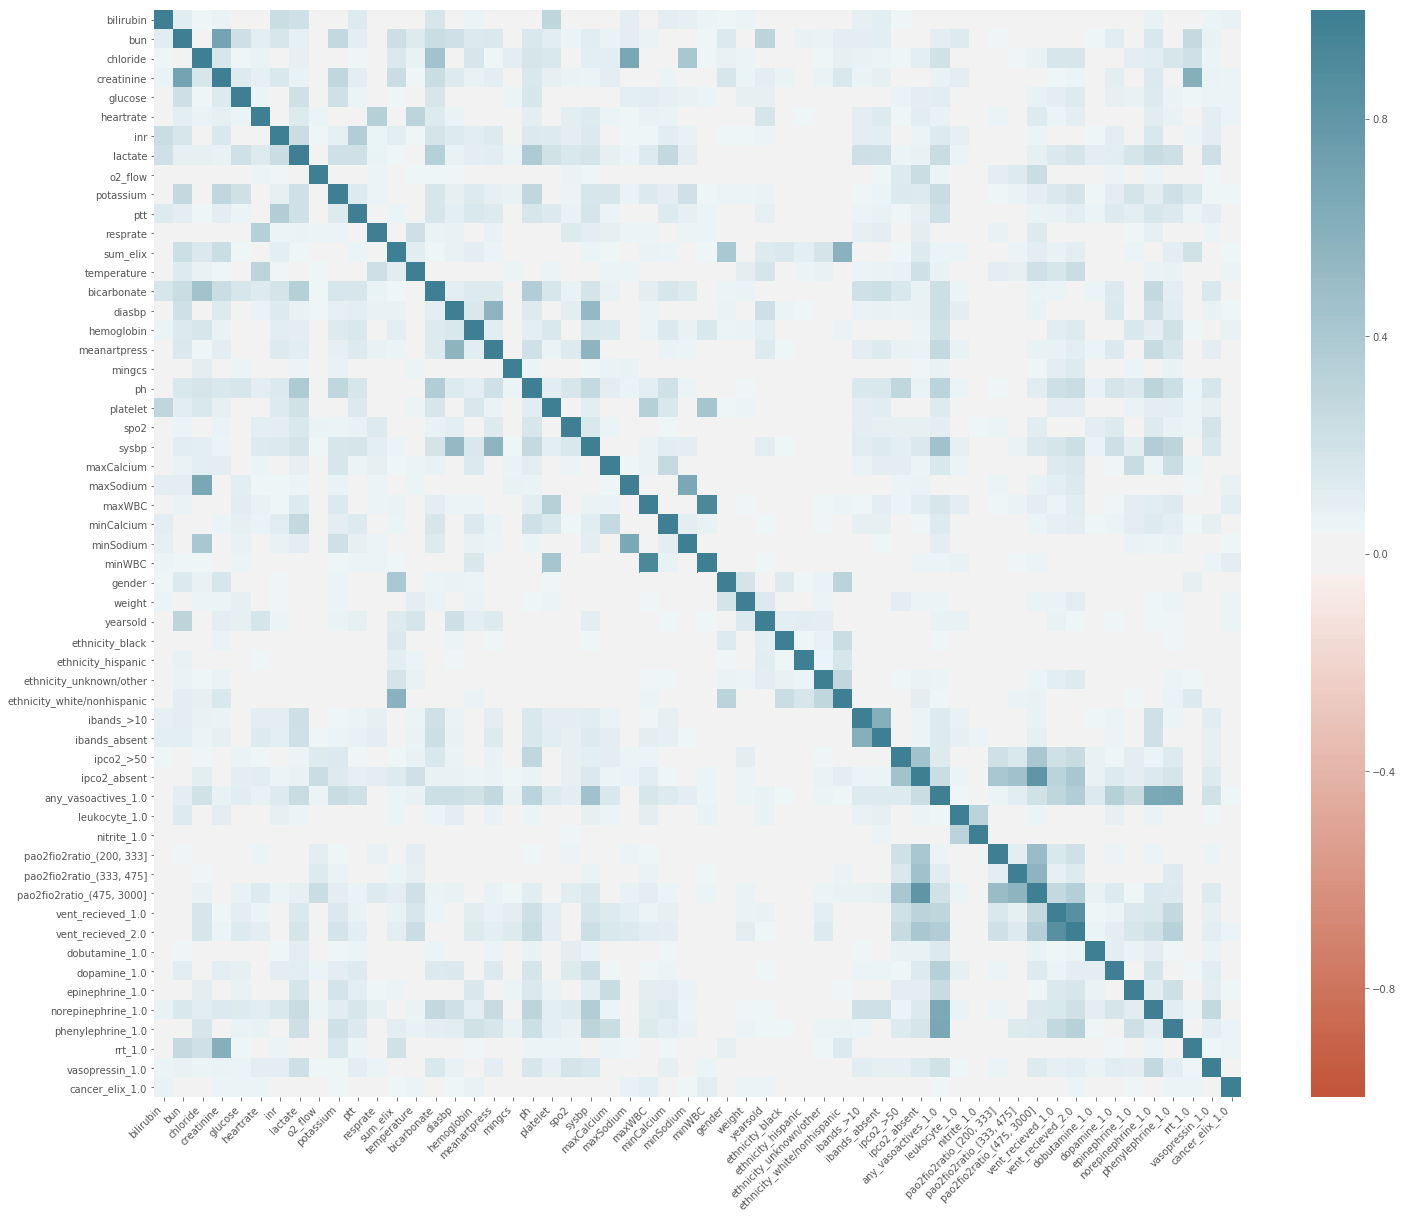

time: 1.96 s


In [27]:
corr = x_train.corr().abs()

plt.figure(figsize=(25, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [28]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2.head()

,corx,cory,corr
0,maxWBC,minWBC,0.915240
1,vent_recieved_1.0,vent_recieved_2.0,0.853540
2,ipco2_absent,"pao2fio2ratio_(475, 3000]",0.814699


time: 18.6 ms


### DROPING one of the 2 columns with correlation >0.7

	corx	cory	corr
0	ipco2_absent	pao2fio2Ratio_(475, 3000]	0.872418
1	maxWBC	minWBC	0.802373
2	bun	creatinine	0.720861
3	maxSodium	minSodium	0.704233

In [29]:
x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 3.96 ms


### formatting x and y for modleing

In [30]:
x=np.array(x_train.copy())
y=y_train.copy() #copy of y_train
y=y.astype('int')
#time_interval=4

time: 3.69 ms


In [31]:
print(len(x_train),len(x_test))

7205 3100
time: 1.04 ms


In [32]:
len(list(x_train))

53

time: 2.22 ms


In [33]:
def save_df(df, df_name='default', rel_path='/data/final/'):
    """
    simple function for saving result table. uses the date and supplied df name and saves to the savepath specified above.
    """
    global folder
    
    save_path= str(repository_path)+rel_path
    
    address=save_path+'{}/'.format(folder)
    if not os.path.exists(address):
        print(address)
        os.makedirs(address)
    else:
        print(address)
        
    if address.endswith('/')==False:
        address= address+'/'
        
    if df_name == 'default':
        df_name =[x for x in globals() if globals()[x] is df][0]
        
    pd.DataFrame(df).to_csv(Path(address+'{}_{}.csv'.format(date, df_name)))


time: 17.9 ms


In [34]:
save_df(x_train, 'x_train_final', rel_path='/data/final/')
save_df(x_test, 'x_test_final', rel_path='/data/final/')
save_df(y_train, 'y_train_final', rel_path='/data/final/')
save_df(y_test, 'y_test_final', rel_path='/data/final/')

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/24_hr_window/
time: 744 ms


# Modelbuilding
## test entire trainset and predict trainset.
* step1) hypertune and evaluate models on 10fold cv.  
* step2) test entire train set and predict testset.
* step3) generate figures

In [35]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import log_loss
    
    y_hat = model.predict(test_features)
    errors = abs(y_hat - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    auc=roc_auc_score(test_labels, y_hat)
    loss= log_loss(test_labels, y_hat)
    
    print ('the AUC is: {:0.3f}'.format(auc))
    print ('the logloss is: {:0.3f}'.format(loss))
    print(confusion_matrix(test_labels, y_hat))
    print(classification_report(test_labels,y_hat, digits=3))
    return (loss)

time: 9.48 ms


In [36]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, base_model, scoring="neg_log_loss", gridsearch=True, n_iter=20, verbose=False): 
    from sklearn.model_selection import GroupKFold
    ## 11/7/19: improvement: added in groupKFold and group on subject_id, this makes 
    np.random.seed(12345)
    if gridsearch==True:
        grid_search = GridSearchCV(estimator= model,
                                         param_grid=param_grid,
                                         cv=GroupKFold(nfolds),
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    else:
        grid_search = RandomizedSearchCV(estimator= model,
                                         param_distributions= param_grid,
                                         n_iter=n_iter,
                                         cv=GroupKFold(nfolds),
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    #grid_search.fit(X, y)    
    grid_search.fit(X, y, groups=z_subject_id)    
    
    print("Grid scores on development set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    #grid_search.best_params_
    print('best score/param: ', grid_search.best_score_)
    print(grid_search.best_params_)
    
    print('\n base model:')
    base_model = base_model#(random_state = 42)
    base_model.fit(x, y)
    base_auc = evaluate(base_model, x, y)
    
    print('\n hypertuned model:')
    best_random = grid_search.best_estimator_
    random_auc = evaluate(best_random, x, y)

    print('logloss change of {:0.2f}%. after hypertuning on training set (may be overfit)'.format( 100 * (random_auc - base_auc) / base_auc))
    
    print(grid_search.best_estimator_)
    
    return(grid_search)

time: 61.1 ms


In [37]:
def hypertuned_cv_fxn(model, nfolds):
    """
    the goal of this function is to take the best hypertuned model and 
    generate average and std for F-1, precision, recall, npv, and AUC across each fold.
    """
    
    from sklearn.model_selection import GroupKFold
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    
    pos_label=1
    
    np.random.seed(12345)
    group_kfold = GroupKFold(n_splits=nfolds)
    group_kfold.get_n_splits(x, y, z_subject_id)

    f1_y_cv=[]
    auc_y_cv=[]
    prec_y_cv=[]
    recall_y_cv=[]
    npv_y_cv=[]

    for train_index, test_index in group_kfold.split(x, y, z_subject_id):
        x_train_cv, x_test_cv = x[train_index], x[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        model.fit(x_train_cv, y_train_cv)
        
        y_proba = model.predict_proba(x_test_cv)[:,1]
        y_pred = model.predict(x_test_cv)

        fpr, tpr, thresholds = metrics.roc_curve(y_test_cv, y_proba, pos_label=pos_label)    
        #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
        youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
        y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]
            
        npv_y=confusion_matrix(y_test_cv, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
        npv_y_cv.append(npv_y)

        prec_y= precision_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        prec_y_cv.append(prec_y)

        recall_y= recall_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        recall_y_cv.append(recall_y)

        f1_y= f1_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        f1_y_cv.append(f1_y)

        ###need to debug this.###
        auc_y=roc_auc_score(y_true=y_test_cv, y_score= y_proba)
        auc_y_cv.append(auc_y)
        
        youden_dic_cv= {'model':type(model).__name__, 
                'auc':np.mean(auc_y_cv),
                'auc_sd':np.std(auc_y_cv),
                'precision':np.mean(prec_y_cv),
                'precision_sd':np.std(prec_y_cv),
                'recall':np.mean(recall_y_cv),
                'recall_sd':np.std(recall_y_cv),
                'f1':np.mean(f1_y_cv),
                'f1_sd':np.std(f1_y_cv),
                'npv':np.mean(npv_y_cv),
                'npv_sd':np.std(npv_y_cv)}
        
    return(youden_dic_cv)

time: 83 ms


## youden index and plotting functions

In [38]:
def saveplot(plt, figure_name):
    """
    simple function for saving plots
    """
    address = str(repository_path)+'/figures/{}'.format(folder)

    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')

def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save_boolean,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='x', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="M_Youden",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    if save==True:
        saveplot(plt, figure_name="{}_roc".format(model_name))
    else: pass
    
    plt.show()
    
    ##depreciated: was a nifty function to save a table as a .png, but i don't use it anymore
# def plot_table_as_fig(table_in, col_labels, row_labels, save=False,model_name=None,folder_name=None, file_name=None,figsize=(6,1)):
    
#     fig = plt.figure(figsize=figsize)
#     table = plt.table(cellText = table_in, 
#                   colLabels = col_labels,
#                   rowLabels = row_labels,
#                   loc='best')
#     plt.axis("tight")
#     plt.axis('off')
#     if save==True:
#         if folder_name != None:
#             address = 'figures/{}/'.format(folder_name)
#         else:
#             address = 'figures/'
#         if not os.path.exists(address):
#             os.makedirs(address)
#         plt.savefig(address+"/{}_{}.png".format(model_name,file_name),bbox_inches='tight')
#     else: pass
    
#     plt.show()
    

time: 167 ms


## step1) hypertuning and cv
* xgboost
* randomforest
* support vector classifier
* logistic regression (l1 and l2)
* k-nearest neighbors

In [39]:
###xgboost
model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27)
scale_pos_weight = [0.1, 1, 5, 10]
max_depth = [1, 2, 3, 4, 5]
learning_rate=[0.01, 0.1, 0.5, 1]
param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}

base_model=XGBClassifier(random_state = 42)
xgboost_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=20, gridsearch=False)


Grid scores on development set:
best score/param:  -0.44291272781463564
{'scale_pos_weight': 1, 'max_depth': 2, 'learning_rate': 0.1}

 base model:
the AUC is: 0.673
the logloss is: 5.752
[[5377  135]
 [1065  628]]
              precision    recall  f1-score   support

           0      0.835     0.976     0.900      5512
           1      0.823     0.371     0.511      1693

   micro avg      0.833     0.833     0.833      7205
   macro avg      0.829     0.673     0.706      7205
weighted avg      0.832     0.833     0.808      7205


 hypertuned model:
the AUC is: 0.641
the logloss is: 6.356
[[5355  157]
 [1169  524]]
              precision    recall  f1-score   support

           0      0.821     0.972     0.890      5512
           1      0.769     0.310     0.441      1693

   micro avg      0.816     0.816     0.816      7205
   macro avg      0.795     0.641     0.666      7205
weighted avg      0.809     0.816     0.784      7205

logloss change of 10.50%. after hypertuning 

In [40]:
xgboost_cv= hypertuned_cv_fxn(xgboost_hyper.best_estimator_, nfolds=10)

time: 10.9 s


In [41]:
xgboost_cv

{'auc': 0.7888842251208966,
 'auc_sd': 0.015054969345137871,
 'f1': 0.487633632872374,
 'f1_sd': 0.036604473843931035,
 'model': 'XGBClassifier',
 'npv': 0.9396745610281927,
 'npv_sd': 0.008197752958430924,
 'precision': 0.3341873986165516,
 'precision_sd': 0.03355388815094234,
 'recall': 0.9092022275500087,
 'recall_sd': 0.008474537562460225}

time: 2.3 ms


In [42]:
## some scrapped code for evaluating the model during hypertuning and looking at performance of AUC vs logloss in hypertuning (not much):


# model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
#                                               gamma=0, subsample=0.8, colsample_bytree=0.8,
#                                               objective='binary:logistic', n_jobs=-1, seed=27)
# scale_pos_weight = [0.1, 1, 5, 10]
# max_depth = [1, 2, 3, 4, 5]
# learning_rate=[0.01, 0.1, 0.5, 1]
# param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}
# xgboost_hyper2=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="roc_auc", n_iter=20, gridsearch=False)



# model = xgboost_hyper2.best_estimator_

# roc_auc_score(y, model.predict(x))
# evaluate(model, x, y)

# #xgboost_hyper2.fit(x,y)
# #roc_auc_score(y, xgboost_hyper2.best_estimator_.predict(y))
# #xgboost_hyper2.best_estimator_.fit(x,y)#.predict(y)


# from sklearn.model_selection import cross_val_score
# -cross_val_score(xgboost_hyper2.best_estimator_, x, y, scoring='neg_log_loss',cv=10)

time: 3.6 ms


In [43]:
###rf
#{'bootstrap': False, 'class_weight': None, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
# Number of trees in random forest
n_estimators = [10, 200]#[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,'auto', 10]
# Maximum number of levels in tree
max_depth = [5,10, 25]#[int(x) for x in np.linspace(5, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight,
               'bootstrap': bootstrap}

model= RandomForestClassifier(criterion='entropy')
base_model=RandomForestClassifier(random_state = 42, criterion='entropy')

rf_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss",n_iter = 20, gridsearch=False)


Grid scores on development set:
best score/param:  -0.4411255124530277
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 25, 'class_weight': None, 'bootstrap': False}

 base model:
the AUC is: 0.959
the logloss is: 0.676
[[5510    2]
 [ 139 1554]]
              precision    recall  f1-score   support

           0      0.975     1.000     0.987      5512
           1      0.999     0.918     0.957      1693

   micro avg      0.980     0.980     0.980      7205
   macro avg      0.987     0.959     0.972      7205
weighted avg      0.981     0.980     0.980      7205


 hypertuned model:
the AUC is: 1.000
the logloss is: 0.000
[[5512    0]
 [   0 1693]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      5512
           1      1.000     1.000     1.000      1693

   micro avg      1.000     1.000     1.000      7205
   macro avg      1.000     1.000     1.000      7205
weighted a

In [44]:
rf_cv= hypertuned_cv_fxn(rf_hyper.best_estimator_, nfolds=10)

time: 41.4 s


In [45]:
### 10/30 72hr model:
# RandomForestClassifier(bootstrap=False, class_weight=None,
#             criterion='entropy', max_depth=25, max_features=10,
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=5,
#             min_samples_split=5, min_weight_fraction_leaf=0.0,
#             n_estimators=200, n_jobs=None, oob_score=False,
#             random_state=None, verbose=0, warm_start=False)

### 11/7 72hr model (groupKfold, no daily_sofa):
# RandomForestClassifier(bootstrap=False, class_weight=None,
#             criterion='entropy', max_depth=25, max_features='auto',
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=10,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             n_estimators=200, n_jobs=None, oob_score=False,
#             random_state=None, verbose=0, warm_start=False)


### 48 hr model:
# RandomForestClassifier(bootstrap=False, class_weight=None,
#             criterion='entropy', max_depth=25, max_features='auto',
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=5,
#             min_samples_split=10, min_weight_fraction_leaf=0.0,
#             n_estimators=200, n_jobs=None, oob_score=False,
#             random_state=None, verbose=0, warm_start=False)

time: 3.89 ms


## Hypertune SVC

In [46]:
model= svm.SVC(probability=True)
kernel = ['linear', 'rbf','poly']
#gamma = [0.1, 1, 'auto'] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default=’auto’ uses 1 / n_features
C = [0.1, 1, 10, 100] #Penalty parameter C of the error term.
degree = [1,2]
class_weight=['balanced', None]

param_grid = {'kernel': kernel,
              #'gamma': gamma,
              'C': C,
              'degree': degree,
              'class_weight':class_weight}

base_model=svm.SVC(probability=True)

svc_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=5, gridsearch=False)
#svc_hyper=hypertuning_fxn(x, y, nfolds=4, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=10, gridsearch=False)

Grid scores on development set:
best score/param:  -0.45232712850946744
{'kernel': 'linear', 'degree': 1, 'class_weight': 'balanced', 'C': 1}

 base model:
the AUC is: 0.563
the logloss is: 7.239
[[5466   46]
 [1464  229]]
              precision    recall  f1-score   support

           0      0.789     0.992     0.879      5512
           1      0.833     0.135     0.233      1693

   micro avg      0.790     0.790     0.790      7205
   macro avg      0.811     0.563     0.556      7205
weighted avg      0.799     0.790     0.727      7205


 hypertuned model:
the AUC is: 0.709
the logloss is: 9.099
[[4197 1315]
 [ 583 1110]]
              precision    recall  f1-score   support

           0      0.878     0.761     0.816      5512
           1      0.458     0.656     0.539      1693

   micro avg      0.737     0.737     0.737      7205
   macro avg      0.668     0.709     0.677      7205
weighted avg      0.779     0.737     0.751      7205

logloss change of 25.70%. after hype

In [47]:
svc_cv= hypertuned_cv_fxn(svc_hyper.best_estimator_, nfolds=10)

time: 2min


In [48]:
###logreg
model= LogisticRegression()
            #model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None)

penalty = ['l1','l2']
class_weight=['balanced',None]


param_grid = {'penalty': penalty,
              'class_weight': class_weight}

base_model=LogisticRegression()

logreg_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=20, gridsearch=True)

Grid scores on development set:
best score/param:  -0.4489749103974173
{'class_weight': None, 'penalty': 'l1'}

 base model:
the AUC is: 0.629
the logloss is: 6.774
[[5288  224]
 [1189  504]]
              precision    recall  f1-score   support

           0      0.816     0.959     0.882      5512
           1      0.692     0.298     0.416      1693

   micro avg      0.804     0.804     0.804      7205
   macro avg      0.754     0.629     0.649      7205
weighted avg      0.787     0.804     0.773      7205


 hypertuned model:
the AUC is: 0.635
the logloss is: 6.692
[[5279  233]
 [1163  530]]
              precision    recall  f1-score   support

           0      0.819     0.958     0.883      5512
           1      0.695     0.313     0.432      1693

   micro avg      0.806     0.806     0.806      7205
   macro avg      0.757     0.635     0.657      7205
weighted avg      0.790     0.806     0.777      7205

logloss change of -1.20%. after hypertuning on training set (may be

In [49]:
logreg_cv= hypertuned_cv_fxn(logreg_hyper.best_estimator_, nfolds=10)

time: 1.57 s


In [50]:
###knn
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier()

n_neighbors = [3,4,5, 8, 10, 25]
weights=['uniform']
p=[1,2] #1= mmanhattan, 2= euclidian


param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'p': p}

base_model=KNeighborsClassifier()

knn_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=20, gridsearch=True)

Grid scores on development set:
best score/param:  -0.5933897603236595
{'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}

 base model:
the AUC is: 0.663
the logloss is: 6.131
[[5315  197]
 [1082  611]]
              precision    recall  f1-score   support

           0      0.831     0.964     0.893      5512
           1      0.756     0.361     0.489      1693

   micro avg      0.822     0.822     0.822      7205
   macro avg      0.794     0.663     0.691      7205
weighted avg      0.813     0.822     0.798      7205


 hypertuned model:
the AUC is: 0.562
the logloss is: 7.291
[[5456   56]
 [1465  228]]
              precision    recall  f1-score   support

           0      0.788     0.990     0.878      5512
           1      0.803     0.135     0.231      1693

   micro avg      0.789     0.789     0.789      7205
   macro avg      0.796     0.562     0.554      7205
weighted avg      0.792     0.789     0.726      7205

logloss change of 18.92%. after hypertuning on training s

In [51]:
knn_cv= hypertuned_cv_fxn(knn_hyper.best_estimator_, nfolds=10)

time: 5.89 s


In [52]:
cv_summary_df= pd.DataFrame([rf_cv,
                               logreg_cv,
                             xgboost_cv,
                             svc_cv,
                              knn_cv])
cv_summary_df= cv_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)

save_df(cv_summary_df, df_name='default', rel_path='/tables/')
cv_summary_df

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/24_hr_window/


,auc,auc_sd,f1,f1_sd,npv,npv_sd,precision,precision_sd,recall,recall_sd
model,,,,,,,,,,
RandomForestClassifier,0.789,0.015,0.486,0.034,0.938,0.010,0.333,0.032,0.907,0.014
XGBClassifier,0.789,0.015,0.488,0.037,0.940,0.008,0.334,0.034,0.909,0.008
LogisticRegression,0.777,0.021,0.474,0.038,0.939,0.014,0.321,0.034,0.916,0.018
SVC,0.774,0.021,0.472,0.038,0.933,0.011,0.320,0.033,0.908,0.008
KNeighborsClassifier,0.710,0.016,0.420,0.024,0.911,0.021,0.272,0.020,0.926,0.015


time: 25.4 ms


# Hypertuned Model Initialization

In [53]:
def reset_model(model_name, hardcode=False):
    if model_name== 'xgboost':
        model = xgboost_hyper.best_estimator_

    elif model_name== 'logreg':
        model = logreg_hyper.best_estimator_

    elif model_name== 'rf': 
        model = rf_hyper.best_estimator_

    elif model_name== 'svc':
        model = svc_hyper.best_estimator_

    elif model_name== 'knn':
        model = knn_hyper.best_estimator_
        
    return(model)

time: 7.95 ms


# test entire trainset and predict testset.
*<del> step1) hypertune xgb via 10fold cv.
* step2) test entire trainset and predict testset.
* step3) generate figures

In [54]:
def get_auc_score(model,train_index, x=x,y=y):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 2.3 ms


## youden index and plotting functions

In [55]:
def saveplot(plt, figure_name):
    """
    simple function for saving plots
    """
    address = str(repository_path)+'/figures/{}'.format(folder)

    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')

def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save_boolean,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='x', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="M_Youden",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    if save==True:
        saveplot(plt, figure_name="{}_roc".format(model_name))
    else: pass
    
    plt.show()
    
    ##depreciated: was a nifty function to save a table as a .png, but i don't use it anymore
# def plot_table_as_fig(table_in, col_labels, row_labels, save=False,model_name=None,folder_name=None, file_name=None,figsize=(6,1)):
    
#     fig = plt.figure(figsize=figsize)
#     table = plt.table(cellText = table_in, 
#                   colLabels = col_labels,
#                   rowLabels = row_labels,
#                   loc='best')
#     plt.axis("tight")
#     plt.axis('off')
#     if save==True:
#         if folder_name != None:
#             address = 'figures/{}/'.format(folder_name)
#         else:
#             address = 'figures/'
#         if not os.path.exists(address):
#             os.makedirs(address)
#         plt.savefig(address+"/{}_{}.png".format(model_name,file_name),bbox_inches='tight')
#     else: pass
    
#     plt.show()
    

time: 162 ms


In [56]:
def classifier_eval(model, x=x, y=y, proba_input=False,pos_label=1, print_default=True,model_name=None, folder_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    """
    classification evaluation function. able to print/save the following:
    
    print/save the following:
        ROC curve marked with threshold for optimal youden (maximizing tpr+fpr with constraint that tpr>0.9)

        using 0.5 threshold:
            confusion matrix
            classification report
            npv
            accuracy

        using optimal youden (maximizing tpr+fpr with constraint that tpr>0.9):
            confusion matrix
            classification report
            npv
            accuracy
    
    output: 
        outputs modelname, auc, precision, recall, f1, and npv to a dictionary. 
    
    notes:
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    """
    
    if proba_input==True: 
        y_proba= model
        y_pred=[1 if y >= 0.5 else 0 for y in y_proba]
    
    else:
        model_name=type(model).__name__

        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save_boolean, model_name=model_name,folder_name=folder)
    plt.show(), plt.close()
    
    #printing npv, recall, precision, accuracy
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: ###can opt to not print the 0.5 classification threshold classification report/conf matrix
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.3f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred, digits=3))
    else:
        pass
    
    #### YOUDEN ADJUSTMENT #####

    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.3f}".format(youden_threshold))

    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
    
    ##plotting and saving confusion matrix
    confusion_youden=confusion_matrix(y, y_pred_youden)
    
    #plotting confusion matrixs
    print(confusion_matrix(y, y_pred_youden))
    print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred_youden)))
    print ("npv: {:01.3f}".format(npv_y))
    print ('the classification_report:\n', classification_report(y,y_pred_youden, digits=3))
    
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    return(youden_dic)
    

time: 151 ms


# testing model

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 10fold cv.
    
<del> * step2) test entire train set and predict testset.
* step3) generate figures


In [57]:
#setting up test table
test_summary_df= pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[], 'npv':[]})
test_summary_df

,model,auc,precision,recall,f1,npv


time: 8.06 ms


### model fitting

In [58]:
xgboost = reset_model('xgboost')
xgboost.fit(x, y)

logreg = reset_model('logreg')
logreg.fit(x, y)

rf= reset_model('rf')
rf.fit(x,y)

# from sklearn.naive_bayes import GaussianNB
# gnb =GaussianNB()
# nb_y_pred = gnb.fit(x, y)

svc= reset_model('svc')
svc.fit(x, y)

knn= reset_model('knn')
knn.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

time: 21.9 s


### global model test set evaluation

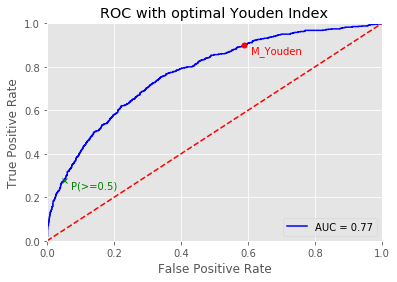


******* Using 0.5 Classification Threshold *******

[[1781  574]
 [ 274  471]]
the Accuracy is: 0.726
npv: 0.867
the classification_report:
               precision    recall  f1-score   support

         0.0      0.867     0.756     0.808      2355
         1.0      0.451     0.632     0.526       745

   micro avg      0.726     0.726     0.726      3100
   macro avg      0.659     0.694     0.667      3100
weighted avg      0.767     0.726     0.740      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.122
[[ 971 1384]
 [  73  672]]
the Accuracy is: 0.530
npv: 0.930
the classification_report:
               precision    recall  f1-score   support

         0.0      0.930     0.412     0.571      2355
         1.0      0.327     0.902     0.480       745

   micro avg      0.530     0.530     0.530      3100
   macro avg      0.628     0.657     0.526      3100
weighted avg      0.785     0.530     0.549      3100

time: 1.44 s


In [59]:
from parameters import save_boolean
svc_eval= classifier_eval(svc, x=np.array(x_test), y=y_test, model_name='svc', folder_name=folder)

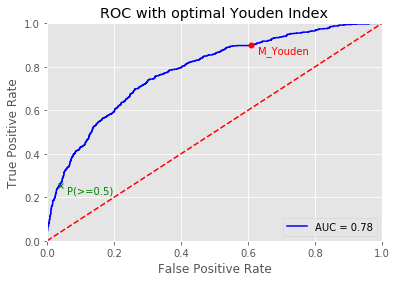


******* Using 0.5 Classification Threshold *******

[[2265   90]
 [ 554  191]]
the Accuracy is: 0.792
npv: 0.803
the classification_report:
               precision    recall  f1-score   support

         0.0      0.803     0.962     0.876      2355
         1.0      0.680     0.256     0.372       745

   micro avg      0.792     0.792     0.792      3100
   macro avg      0.742     0.609     0.624      3100
weighted avg      0.774     0.792     0.755      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.129
[[ 918 1437]
 [  73  672]]
the Accuracy is: 0.513
npv: 0.926
the classification_report:
               precision    recall  f1-score   support

         0.0      0.926     0.390     0.549      2355
         1.0      0.319     0.902     0.471       745

   micro avg      0.513     0.513     0.513      3100
   macro avg      0.622     0.646     0.510      3100
weighted avg      0.780     0.513     0.530      3100

time: 384 ms


In [60]:
xgboost_eval= classifier_eval(xgboost, x=np.array(x_test), y=y_test, model_name='xgboost', folder_name=folder)

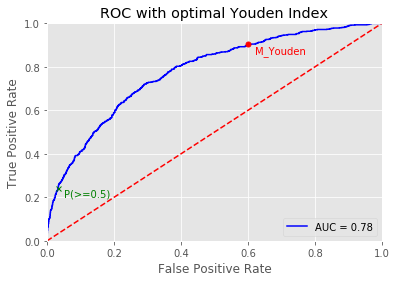


******* Using 0.5 Classification Threshold *******

[[2280   75]
 [ 566  179]]
the Accuracy is: 0.793
npv: 0.801
the classification_report:
               precision    recall  f1-score   support

         0.0      0.801     0.968     0.877      2355
         1.0      0.705     0.240     0.358       745

   micro avg      0.793     0.793     0.793      3100
   macro avg      0.753     0.604     0.618      3100
weighted avg      0.778     0.793     0.752      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.136
[[ 939 1416]
 [  72  673]]
the Accuracy is: 0.520
npv: 0.929
the classification_report:
               precision    recall  f1-score   support

         0.0      0.929     0.399     0.558      2355
         1.0      0.322     0.903     0.475       745

   micro avg      0.520     0.520     0.520      3100
   macro avg      0.625     0.651     0.516      3100
weighted avg      0.783     0.520     0.538      3100

time: 586 ms


In [61]:
rf_eval= classifier_eval(rf, x=np.array(x_test), y=y_test, model_name='rf', folder_name=folder)

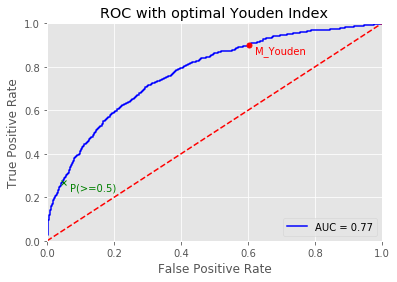


******* Using 0.5 Classification Threshold *******

[[2244  111]
 [ 542  203]]
the Accuracy is: 0.789
npv: 0.805
the classification_report:
               precision    recall  f1-score   support

         0.0      0.805     0.953     0.873      2355
         1.0      0.646     0.272     0.383       745

   micro avg      0.789     0.789     0.789      3100
   macro avg      0.726     0.613     0.628      3100
weighted avg      0.767     0.789     0.755      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.117
[[ 938 1417]
 [  73  672]]
the Accuracy is: 0.519
npv: 0.928
the classification_report:
               precision    recall  f1-score   support

         0.0      0.928     0.398     0.557      2355
         1.0      0.322     0.902     0.474       745

   micro avg      0.519     0.519     0.519      3100
   macro avg      0.625     0.650     0.516      3100
weighted avg      0.782     0.519     0.537      3100

time: 375 ms


In [62]:
# logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test)
logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test, model_name='logreg', folder_name=folder)

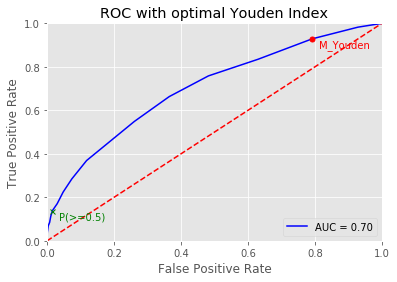


******* Using 0.5 Classification Threshold *******

[[2329   26]
 [ 661   84]]
the Accuracy is: 0.778
npv: 0.779
the classification_report:
               precision    recall  f1-score   support

         0.0      0.779     0.989     0.871      2355
         1.0      0.764     0.113     0.196       745

   micro avg      0.778     0.778     0.778      3100
   macro avg      0.771     0.551     0.534      3100
weighted avg      0.775     0.778     0.709      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.080
[[ 490 1865]
 [  53  692]]
the Accuracy is: 0.381
npv: 0.902
the classification_report:
               precision    recall  f1-score   support

         0.0      0.902     0.208     0.338      2355
         1.0      0.271     0.929     0.419       745

   micro avg      0.381     0.381     0.381      3100
   macro avg      0.587     0.568     0.379      3100
weighted avg      0.751     0.381     0.358      3100

time: 2.98 s


In [63]:
knn_eval= classifier_eval(knn, x=np.array(x_test), y=y_test, model_name='knn', folder_name=folder)

# classification performance table

In [64]:
test_summary_df= pd.DataFrame([xgboost_eval, rf_eval, logreg_eval, svc_eval,knn_eval])
test_summary_df=test_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)
save_df(test_summary_df, df_name='default', rel_path='/tables/')
print(test_summary_df)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/24_hr_window/
                          auc     f1    npv  precision  recall
model                                                         
XGBClassifier           0.782  0.471  0.926      0.319   0.902
RandomForestClassifier  0.778  0.475  0.929      0.322   0.903
LogisticRegression      0.773  0.474  0.928      0.322   0.902
SVC                     0.772  0.480  0.930      0.327   0.902
KNeighborsClassifier    0.702  0.419  0.902      0.271   0.929
time: 12.6 ms


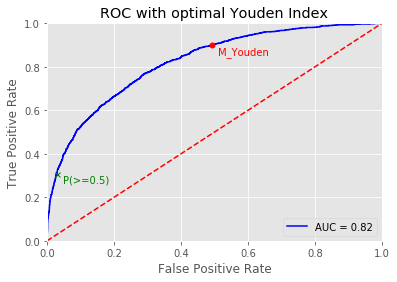


******* Using 0.5 Classification Threshold *******

[[5355  157]
 [1169  524]]
the Accuracy is: 0.816
npv: 0.821
the classification_report:
               precision    recall  f1-score   support

         0.0      0.821     0.972     0.890      5512
         1.0      0.769     0.310     0.441      1693

   micro avg      0.816     0.816     0.816      7205
   macro avg      0.795     0.641     0.666      7205
weighted avg      0.809     0.816     0.784      7205


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.149
[[2800 2712]
 [ 169 1524]]
the Accuracy is: 0.600
npv: 0.943
the classification_report:
               precision    recall  f1-score   support

         0.0      0.943     0.508     0.660      5512
         1.0      0.360     0.900     0.514      1693

   micro avg      0.600     0.600     0.600      7205
   macro avg      0.651     0.704     0.587      7205
weighted avg      0.806     0.600     0.626      7205

time: 500 ms


In [65]:
xgboost_train= classifier_eval(xgboost, x=np.array(x_train), y=y_train, model_name='xgboost_train', folder_name=folder)

# generating publication stacked roc curve 

In [66]:
def roc_publishing(model, x=x, y=y, proba_input=False,pos_label=1, print_default=True, model_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    model_name=type(model).__name__

    y_pred = model.predict(x)
    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    return(fpr, tpr, roc_auc, roc_df, idx)
    

time: 14.9 ms


In [67]:
# plt.style.use('seaborn-white')
# plt.rcParams['figure.figsize'] = [5, 5]

# fpr, tpr, roc_auc, roc_df, idx= roc_publishing(xgboost, x=np.array(x_test), y=y_test, model_name='xgboost')

# plt.title('ROC with optimal Youden Index')
# ax= plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')

# #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
# og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
# plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="purple")
# plt.annotate(s="P(0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='purple', size=14, weight='bold') #textcoords

# plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
# plt.annotate(s="P(0.12)",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r', size=14, weight='bold' ) #textcoords
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate', size=14)
# plt.xlabel('False Positive Rate', size=14)

# plt.show()


time: 2.97 ms


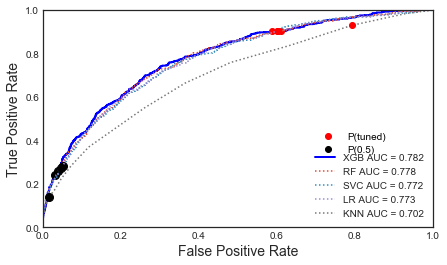

time: 4.5 s


In [68]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = [7, 4]
##########xgb
model_name='XGB'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(xgboost, x=np.array(x_test), y=y_test, model_name='xgboost')
#plt.title('ROC with optimal Youden Index')
ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
#plt.annotate(s="P(0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='purple', size=14, weight='bold') #textcoords
plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
#plt.annotate(s="P(0.12)",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r', size=14, weight='bold' ) #textcoords

###########rf
model_name='RF'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(rf, x=np.array(x_test), y=y_test, model_name='rf')
ax2= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##

###########svc
model_name='SVC'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(svc, x=np.array(x_test), y=y_test, model_name='svc')
ax3= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##

###########logreg
model_name='LR'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(logreg, x=np.array(x_test), y=y_test, model_name='lr')
ax4= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##

###########knn
model_name='KNN'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(knn, x=np.array(x_test), y=y_test, model_name='knn')
ax5= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc),linestyle='dotted')
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
ax6=plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
ax7=plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
plt.legend(loc = 'lower right')

#plt.legend((ax1,ax2,ax3,ax4,ax5,ax6,ax7), loc = 'lower right')
plt.annotate(s="P(0.5)",xy=(0.78, 0.345),color='black', size=10) #textcoords
plt.plot(0.73, 0.36, 'ro', color='black')
plt.annotate(s="P(tuned)",xy=(0.78, 0.405),color='black', size=10) #textcoords
plt.plot(0.73, 0.42, 'ro', color='r')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', size=14)
plt.xlabel('False Positive Rate', size=14)

saveplot(plt,'stacked_roc')

plt.show()

# variable importance

In [69]:
def var_imp(model,folder_name,model_name, n_var=4, save=True):
    model_name=type(model).__name__
    plot_title= "Top {} {} {} Variable Importance".format(n_var, folder_name,model_name)
    feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
    topn=feat_importances.nlargest(n_var).sort_values()
    ax=topn.plot(kind='barh', x='variable importance', title=plot_title)#.xlabel("xlab")
    ax.set_xlabel("Variable Importance")
    if save==True:
        saveplot(figure_name=plot_title)
    return(topn)


time: 7.77 ms


In [70]:
#log reg important features

def coef_feature_importance(model):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-10:]#[0]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(x_test.columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()   
    plt.show()
    return(list(np.array(x_test.columns)[sorted_idx][-10:]), feature_importance[sorted_idx])

time: 13.9 ms


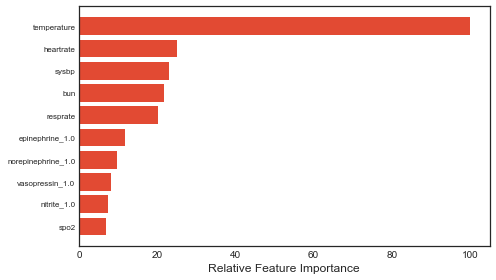

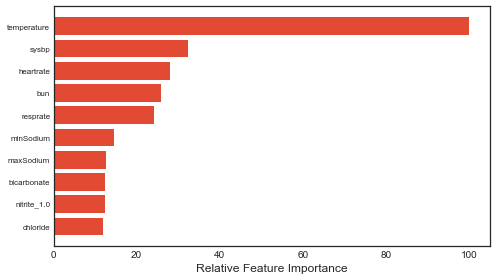

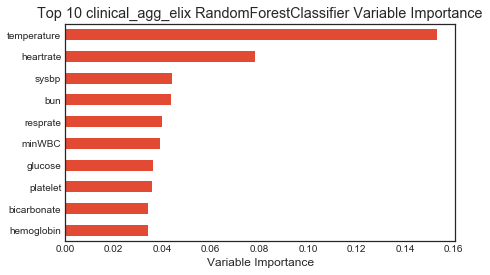

time: 562 ms


In [71]:
logreg_10features,logreg_top10 =coef_feature_importance(logreg)
logreg_top10=pd.Series(logreg_top10,logreg_10features)

svc_10features,svc_top10 =coef_feature_importance(svc)
svc_top10=pd.Series(svc_top10,svc_10features)


xgb_10features=var_imp(xgboost,"clinical_agg_elix","xgboost", n_var=10, save=False)
rf_10features=var_imp(rf,"clinical_agg_elix","rf", n_var=10, save=False)
xgb_top10=(xgb_10features/xgb_10features[-1])*100
rf_top10=(rf_10features/rf_10features[-1])*100
xgb_10features=list(xgb_10features.reset_index()['index'])
rf_10features=list(rf_10features.reset_index()['index'])

In [72]:
df_base=pd.DataFrame(index=set(logreg_10features + svc_10features+ rf_10features +xgb_10features))
df_base['xgb']=xgb_top10
df_base['rf']=rf_top10
df_base['svc']=svc_top10
df_base['lr']=logreg_top10

##use for curosity
varimp_names=list(set(logreg_10features + svc_10features+ rf_10features +xgb_10features))

df_base.index=varimp_names
df_base.sort_values('xgb', ascending=False, inplace=True)

time: 11.5 ms


In [73]:
#df_base[df_base['xgb'].notnull() & df_base['rf'].notnull()& df_base['svc'].notnull() & df_base['lr'].notnull()]

all4=df_base[
    (df_base.iloc[:,0].notnull() &
     df_base.iloc[:,1].notnull()&
     df_base.iloc[:,2].notnull() &
     df_base.iloc[:,3].notnull())
]
all4

#df_base[df_base['xgb'].notnull() & df_base['rf'].notnull()& df_base['svc'].notnull() & df_base['lr'].notnull()]

,xgb,rf,svc,lr
sysbp,28.303736,80.238640,32.369085,22.979157
temperature,25.644175,100.000000,100.000000,100.000000
heartrate,21.415945,81.288113,28.126466,25.169944
resprate,21.141808,72.738136,24.187938,20.242377
bun,19.917517,79.697609,25.917657,21.793059


time: 12.7 ms


In [74]:
[df_base.iloc[:,0].notnull() & df_base.iloc[:,1].notnull()& df_base.iloc[:,2].notnull() & df_base.iloc[:,3].notnull()]

[norepinephrine_1.0           False
 ibands_absent                False
 bicarbonate                  False
 sysbp                         True
 temperature                   True
 pao2fio2ratio_(475, 3000]    False
 leukocyte_1.0                False
 heartrate                     True
 resprate                      True
 bun                           True
 spo2                         False
 glucose                      False
 platelet                     False
 nitrite_1.0                  False
 hemoglobin                   False
 vasopressin_1.0              False
 minSodium                    False
 minWBC                       False
 maxSodium                    False
 epinephrine_1.0              False
 chloride                     False
 dtype: bool]

time: 5.98 ms


In [75]:
df_base

,xgb,rf,svc,lr
norepinephrine_1.0,100.000000,NaN,NaN,9.701868
ibands_absent,51.191795,NaN,NaN,NaN
bicarbonate,28.715382,62.667565,12.363985,NaN
sysbp,28.303736,80.238640,32.369085,22.979157
temperature,25.644175,100.000000,100.000000,100.000000
"pao2fio2ratio_(475, 3000]",25.505356,NaN,NaN,NaN
leukocyte_1.0,22.102369,NaN,NaN,NaN
heartrate,21.415945,81.288113,28.126466,25.169944
resprate,21.141808,72.738136,24.187938,20.242377
bun,19.917517,79.697609,25.917657,21.793059


time: 8.6 ms


In [76]:
def roc_name_adjust(varimp_names):
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
            'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
            'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 11.6 ms


In [77]:
i=0
index_list=[]
element_list=[]

# df_base.iloc[:,0].notnull() & df_base.iloc[:,1].notnull()& df_base.iloc[:,2].notnull() & df_base.iloc[:,3].notnull():
    

for element in (df_base.iloc[:,0].notnull() &
                        df_base.iloc[:,1].notnull()&
                        df_base.iloc[:,2].notnull() &
                        df_base.iloc[:,3].notnull()):
    if element ==True:
        index_list.append(i)
        element_list.append(element)
        i+=1
    else:
        i+=1
        pass
print(index_list, df_base.iloc[index_list,:].index)

[3, 4, 7, 8, 9] Index(['sysbp', 'temperature', 'heartrate', 'resprate', 'bun'], dtype='object')
time: 80.7 ms


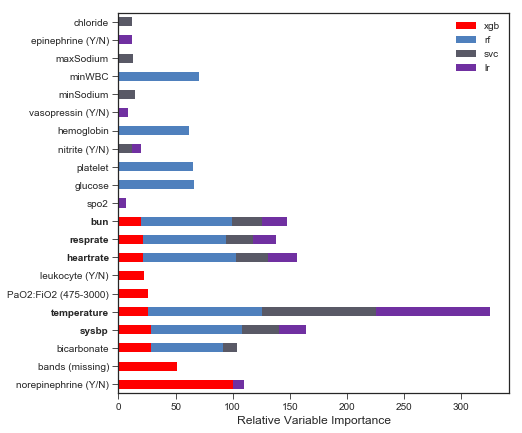

time: 769 ms


In [78]:
adjusted_names = roc_name_adjust(list(df_base.index))
df_base.index=adjusted_names

plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [7, 7]

ax = df_base.plot.barh(stacked=True,
                       grid=False,
                       color=['r',(0.31,0.50,0.74),(0.35,0.35,0.40),(0.44,0.19,0.63)])#facecolor='w')#rot=0) #(0.96,0.59,0.27)
ax.set_facecolor('w')
ax.set_xlabel("Relative Variable Importance")
ax.get_xticklabels()[1]

    
for i in index_list:
    ax.get_yticklabels()[i].set_fontweight('bold')
    #other options:
#     .set_bbox(dict(facecolor='red', alpha=0.2)) #sets a red/pink box around the titles

saveplot(plt,'variable_importance')



## idea: Rashamon effect? what would ensemble look like? 
the ensemble is intresting if the ensemble predicts a different group of patients (or has different variable importance).

rashamon effect where we don't gain from ensemble: identifying same patints in different ways
rashamon effect where we do gain from ensemble: identifying DIFFERENT patients in the different ways

In [79]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[("xgboost", xgboost), ('rf', rf), ('log_reg', logreg), ('svc',svc)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft', n_jobs=-1)
# If ‘hard’, uses predicted class labels for majority rule voting.
# Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities,
# which is recommended for an ensemble of well-calibrated classifiers.

ensemble.fit(x, y)#, sample_weight=np.array([0.67289604, 1.94595562]))

VotingClassifier(estimators=[('xgboost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',...ar', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

time: 15.1 s


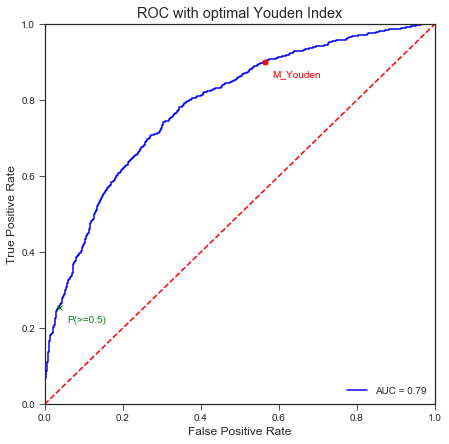


******* Using 0.5 Classification Threshold *******

[[2272   83]
 [ 555  190]]
the Accuracy is: 0.794
npv: 0.804
the classification_report:
               precision    recall  f1-score   support

         0.0      0.804     0.965     0.877      2355
         1.0      0.696     0.255     0.373       745

   micro avg      0.794     0.794     0.794      3100
   macro avg      0.750     0.610     0.625      3100
weighted avg      0.778     0.794     0.756      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.140
[[1028 1327]
 [  74  671]]
the Accuracy is: 0.548
npv: 0.933
the classification_report:
               precision    recall  f1-score   support

         0.0      0.933     0.437     0.595      2355
         1.0      0.336     0.901     0.489       745

   micro avg      0.548     0.548     0.548      3100
   macro avg      0.634     0.669     0.542      3100
weighted avg      0.789     0.548     0.569      3100

time: 1.64 s


In [80]:
ensemble_eval= classifier_eval(ensemble, 
                               x=np.array(x_test),
                               y=y_test, 
                               model_name='ensemble',
                               folder_name=folder)

looks like its the rashamon effect that doesn't benefit from ensembling.

ie there are hidden variables that can discriminate the patients.

# Model Saving

In [81]:
def model_save(model, model_name):
    import pickle
    modelpath=str(repository_path)+'/models/{}'.format(folder)

    if not os.path.exists(modelpath):
        print(modelpath)
        os.makedirs(modelpath)

    filename = str(modelpath)+'/finalized_{}.sav'.format(model_name)
    pickle.dump(model, open(filename, 'wb'))

time: 4.74 ms


In [82]:
model_save(xgboost,'xgboost')
model_save(rf,'rf')
model_save(logreg,'logreg')
model_save(svc,'svc')
model_save(knn,'knn')
model_save(ensemble,'ensemble')

time: 310 ms


In [83]:
folder

'24_hr_window'

time: 1.8 ms


In [84]:
date

'30102019'

time: 2.02 ms
